In [3]:
#Скачиваем данные
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2091k    0 2091k    0     0   531k      0 --:--:--  0:00:02 --:--:-- 65594--:--  0:00:03 --:--:--  531k


In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [17]:
import pandas as pd

counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('/Users/gleb/PyDS_handbook/PythonDataScienceHandbook-master/notebooks/data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [18]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']]  #удаляем остальные столбцы

In [19]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [20]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

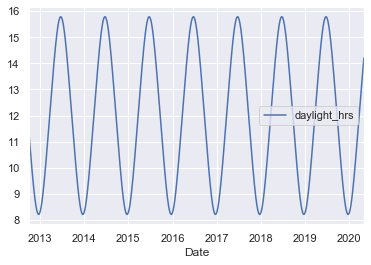

In [21]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Рассчитываем длительность светового дня для заданной даты"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m,0,2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()

In [22]:
#Температуры указаны в десятых долях градуса Цельсия
#Преобразуем в целые градусы
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

#Осадки указанны в десятых долях миллиметра
#преобразуем в дюймы
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [24]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [25]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


In [32]:
daily.dropna(inplace=True)

In [33]:
daily.dtypes

Total           float64
Mon             float64
Tue             float64
Wed             float64
Thu             float64
Fri             float64
Sat             float64
Sun             float64
holiday         float64
daylight_hrs    float64
PRCP            float64
Temp (C)        float64
dry day         float64
annual          float64
dtype: object

In [27]:
from sklearn.linear_model import LinearRegression

In [34]:
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

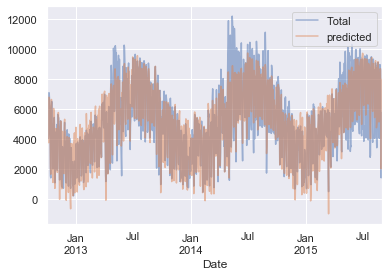

In [35]:
daily[['Total', 'predicted']].plot(alpha=0.5)

In [36]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon             1009.765512
Tue             1220.467872
Wed             1185.347283
Thu              964.716230
Fri              355.960691
Sat            -2206.603421
Sun            -2267.134492
holiday        -2374.802762
daylight_hrs     257.703022
PRCP           -1329.669764
dry day         1095.397185
Temp (C)         130.325582
annual            53.885426
dtype: float64

In [38]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X,y)).coef_
              for i in range(1000)], 0)

In [39]:
print(pd.DataFrame({'effects': params.round(0),
                    'error': err.round(0)}))

              effects  error
Mon            1010.0  173.0
Tue            1220.0  166.0
Wed            1185.0  166.0
Thu             965.0  170.0
Fri             356.0  162.0
Sat           -2207.0  159.0
Sun           -2267.0  166.0
holiday       -2375.0  326.0
daylight_hrs    258.0   18.0
PRCP          -1330.0  125.0
dry day        1095.0   66.0
Temp (C)        130.0    7.0
annual           54.0   35.0
